# Running a hydrological model over a watershed defined by a shapefile

This notebook shows how to run Raven over a user-defined watershed. The watershed contour is provided by a shapefile, which we use to subset meteorological data and to extract watershed physiographic properties. The meteorological data is spatially averaged (crudely for now), then fed to the Raven hydrological model to simulate streamflow. 

In [1]:
# Import the necessary libraries to format, send, and parse our returned results.
# TODO: Cleanup
import os
import json
from birdy import WPSClient
import geopandas as gpd
import ipyleaflet
import ipywidgets


from pathlib import Path
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(url)

If your `notebook` is version prior to `5.3`, you might need to run this command `jupyter nbextension enable --py --sys-prefix ipyleaflet`.  For more information see https://ipyleaflet.readthedocs.io/en/latest/installation.html.

## Select the watershed

In [2]:
# Build an interactive map with ipyleaflet
map_lat_lon = (48, -71)
marker_lat_lon = (47.96, -71.41)
leaflet_map = ipyleaflet.Map(
    center=map_lat_lon,
    basemap=ipyleaflet.basemaps.OpenTopoMap,
)

# Add a custom zoom slider
zoom_slider = ipywidgets.IntSlider(description="Zoom level:", min=1, max=10, value=8)
ipywidgets.jslink((zoom_slider, "value"), (leaflet_map, "zoom"))
widget_control1 = ipyleaflet.WidgetControl(widget=zoom_slider, position="topright")
leaflet_map.add_control(widget_control1)

# Add a marker to the map
marker = ipyleaflet.Marker(location=marker_lat_lon, draggable=True)
leaflet_map.add_layer(marker)

In [3]:
# Add an overlay widget

html = ipywidgets.HTML("""Hover over a feature!""")
html.layout.margin = "0px 10px 10px 10px"

control = ipyleaflet.WidgetControl(widget=html, position="bottomleft")
leaflet_map.add_control(control)


def update_html(feature, **kwargs):
    html.value = """
        <h2><b>USGS HydroBASINS</b></h2>
        <h4>ID: {}</h4>
        <h4>Upstream Area: {} sq. km.</h4> 
        <h4>Sub-basin Area: {} sq. km.</h4>
    """.format(
        feature["properties"]["id"],
        feature["properties"]["UP_AREA"],
        feature["properties"]["SUB_AREA"],
    )


# Load the map in the notebook
leaflet_map

Map(center=[48, -71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

**Before continuing!**

Try dragging and placing the marker at the mouth of a river, over a large lake such as Lac Saint Jean (next to Alma, east of the initial marker position), or anywhere else within North America.

In [4]:
user_lonlat = list(reversed(marker.location))
user_lonlat

[-71.41, 47.96]

## Extract watershed properties

Now we get the watershed contour, physiographic properties, and land cover. 

In [5]:
# Get the shape of the watershed contributing to flow at the selected location.
resp = wps.hydrobasins_select(location=str(user_lonlat), aggregate_upstream=True)

In [6]:
# Before continuing, wait for the process above to finish.

# Extract the URL of the resulting GeoJSON feature
features, ids = resp.get(asobj=True)

user_shape = resp.get(asobj=False).feature


# Add this GeoJSON to the map above!
df = gpd.read_file(user_shape)

user_geojson = ipyleaflet.GeoData(
    geo_dataframe=df,
    style={
        "color": "blue",
        "opacity": 1,
        "weight": 1.9,
        "fillOpacity": 0.5,
    },
    hover_style={"fillColor": "#b08a3e", "fillOpacity": 0.9},
)

leaflet_map.add_layer(user_geojson)

user_geojson.on_hover(update_html)

In [7]:
# Get and store the properties related to the shape of the catchment
resp = wps.shape_properties(shape=user_shape)

[
    properties,
] = resp.get(asobj=True)
prop = properties[0]
basin_area = prop["area"] / 1000000.0
basin_longitude = prop["centroid"][0]
basin_latitude = prop["centroid"][1]
gravelius = prop["gravelius"]
perimeter = prop["perimeter"]
shapeProperties = {
    "area": basin_area,
    "longitude": basin_longitude,
    "latitude": basin_latitude,
    "gravelius": gravelius,
    "perimeter": perimeter,
}

In [8]:
# This uses the HydroSheds DEM
resp = wps.terrain_analysis(
    shape=user_shape, select_all_touching=True, projected_crs=3978
)

# Collect the properties related to the catchment terrain (DEM)
properties, dem = resp.get(asobj=True)
basin_elevation = properties[0]["elevation"]
slope = properties[0]["slope"]
aspect = properties[0]["aspect"]
terrain_data = {"elevation": basin_elevation, "slope": slope, "aspect": aspect}

print("Area: ", basin_area)
print("Elevation: ", basin_elevation)
print("Longitude: ", basin_longitude)
print("Latitude: ", basin_latitude)

Area:  539.0313783446244
Elevation:  770.6216454535962
Longitude:  -71.29316307348144
Latitude:  47.83930090903017


In [9]:
# Use the geoserver to extract the land cover over the appropriate bounding box (automatic)
resp = wps.nalcms_zonal_stats(
    shape=user_shape, select_all_touching=True, band=1, simple_categories=True
)

In [10]:
# Finally, get the information related to the land use
features, statistics = resp.get(asobj=True)
lu = statistics[0]
total = sum(lu.values())
landUse = {k: (v / total) for (k, v) in lu.items()}

# Agregate all properties
all_properties = {**shapeProperties, **landUse, **terrain_data}

# print all properties available
display(all_properties)

{'area': 539.0313783446244,
 'longitude': -71.29316307348144,
 'latitude': 47.83930090903017,
 'gravelius': 2.1749929765886815,
 'perimeter': 179006.91768860785,
 'Ocean': 0.0,
 'Forest': 0.928452760032436,
 'Shrubs': 0.018500754863761924,
 'Grass': 0.0041550470388903174,
 'Wetland': 0.005412603917380326,
 'Crops': 0.0038303567308136045,
 'Urban': 0.008387558262956297,
 'Water': 0.03126091915376146,
 'SnowIce': 0.0,
 'elevation': 770.6216454535962,
 'slope': 6.90094691969857,
 'aspect': 297.27643883428465}

## Extract meteorological variables

Here we're getting temperature and precipitation time series from the ERA5 dataset. Normally, we would compute the average over the watershed, but to speed things up, here we're only getting the grid cells whose centroid fall within the watershed. Since this is a small and narrow watershed, there is only one grid cell returned.

Note that `finch.average_polygon` seems to crash with the ERA5 dataset. This will be investigated.

In [11]:
# SETUP THE RUN PARAMETERS. The data will be extracted to cover the simulation period
start = dt.datetime(2020, 6, 1)
stop = dt.datetime(2020, 6, 10)
UTCoffset_hours = -6  # for UTC delta

finch_url = os.environ.get(
    "FINCH_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps"
)
finch = WPSClient(finch_url)

# NRCAN_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml"
# ERA5_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/era5.ncml"
ERA5_tas = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5_rechunk/tas_era5_reanalysis_hourly_2020.nc"
ERA5_pr = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5_rechunk/pr_era5_reanalysis_hourly_2020.nc"

tas_resp = finch.subset_polygon(
    resource=ERA5_tas, shape=user_shape, start_date=start, end_date=stop
)
pr_resp = finch.subset_polygon(
    resource=ERA5_pr, shape=user_shape, start_date=start, end_date=stop
)

In [12]:
tas_url, ml = tas_resp.get()
pr_url, ml = pr_resp.get()

tas = tas_resp.get(asobj=True).output
display(tas)

<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 217)
Coordinates:
  * time       (time) datetime64[ns] 2020-06-01 ... 2020-06-10
  * latitude   (latitude) float32 47.75
  * longitude  (longitude) float32 288.8
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-09 13:50:26 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    crs:          +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs lon_wrap=1...

## Run the hydrological model

Typically, if you do not have a catchment contour available, you may be working in ungauged basins. Here we implement a regionalization approach to estimate the model parameters based on the catchment descriptors. In the example below, we're regionalizing parameters based on the watershed latitude, longiture and forest cover. 

In [13]:
# SETUP THE RUN PARAMETERS. The data will be extracted to cover the simulation period

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = "GR4JCN"
UTCoffset_hours = -6  # for UTC delta

config = dict(
    start_date=dt.datetime(2020, 6, 2),
    end_date=dt.datetime(2020, 6, 9),
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    method="PS",  # for Physical Similarity
    model_name=hydromodel,
    min_nse=0.7,  # Minimum calibration NSE required to be considered a donor (for selecting good donor catchments)
    ndonors=5,  # Number of donors we want to use. Usually between 4 and 8 is a robust number.
    rain_snow_fraction="RAINSNOW_DINGMAN",
    properties=json.dumps(
        {
            "latitude": basin_latitude,
            "longitude": basin_longitude,
            "forest": all_properties["Forest"],
        }
    ),
    nc_spec=json.dumps(
        {
            "tas": {"offset": -273.15, "time_shift": UTCoffset_hours / 24},
            "pr": {"scale": 24000.0, "time_shift": UTCoffset_hours / 24},
        }
    ),
)

In [14]:
# Here is where we do the regionalization.
resp = wps.regionalisation(ts=[tas_url, pr_url], **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, ensemble] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

The `hydrograph` and `ensemble` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

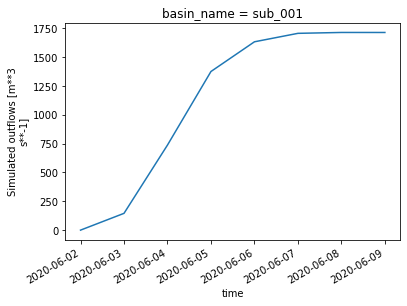

In [15]:
hydrograph.q_sim.plot()

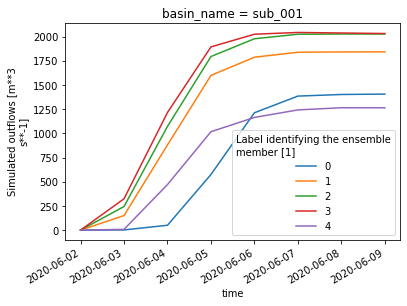

In [16]:
# Plot the simulations from the 5 donor parameter sets
ensemble.q_sim.isel(nbasins=0).plot.line(hue="realization")